# Machine learning from scratch, Neural networks

## Introduction

In this notebook we will build a Neural Network from scratch. As the primary focus of this series of notebooks is educational, we will not build the most general version of a Neural Network, but we will limit it to only one hidden layer, as well as a very simple dataset. This seems quite restrictive, but in fact, it iss powerful enough to showcase the potential of a Neural Network.

We start as usual by importing the scientific libraries needed for this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

As we have seen in the previous parts, we can build a classification algorithm that is able to separate points from a dataset by a linear manifold (for instance, using logistic regression):

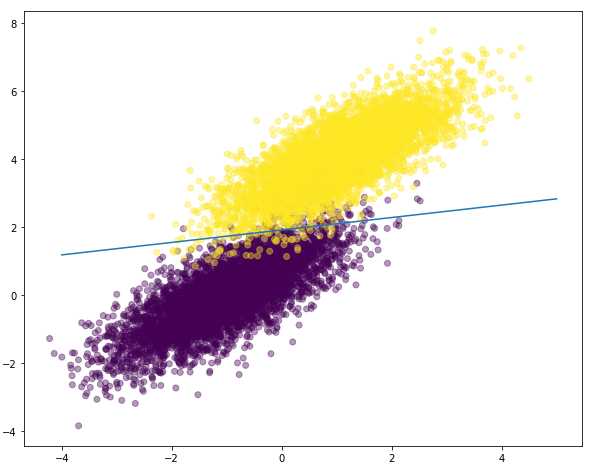

In [2]:
Image(filename='logistic.png') 

Such algorithms have their intrinsic limitations, as there are datasets which will not achieve accurate predictions with a linear decision boundary. See for example the following dataset:

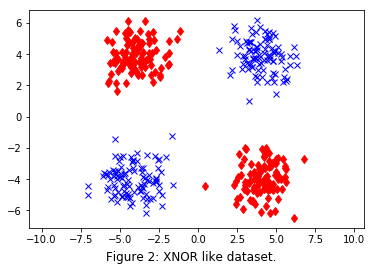

In [3]:
A = np.random.multivariate_normal([-4, -4], [[1, 0],[0, 1]], 100)
B = np.random.multivariate_normal([4, 4], [[1, 0],[0, 1]], 100)
C = np.random.multivariate_normal([-4, 4], [[1, 0],[0, 1]], 100)
D = np.random.multivariate_normal([4, -4], [[1, 0],[0, 1]], 100)
[x0,y0] , [x1,y1] , [x2,y2] , [x3,y3] = A.T , B.T , C.T , D.T

plt.plot([x0,x1],[y0,y1],'x',color='blue')
plt.plot([x2,x3],[y2,y3],'d',color='red')
plt.figtext(0.5, 0.01, 'Figure 2: XNOR like dataset.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('equal')
plt.show()

For this notebook, we will start working with a much more reduced version of this dataset:

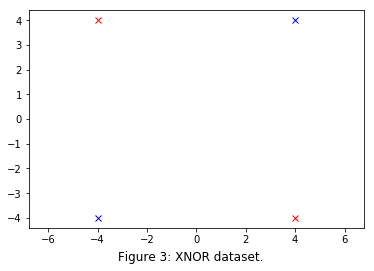

In [4]:
plt.plot([4,-4],[4,-4],'x',color='blue')
plt.plot([4,-4],[-4,4],'x',color='red')
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 3: XNOR dataset.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

Even though this dataset consists of only 4 points (XOR/XNOR situation) separated in two classes (blue and red), it is not hard to convince ourselves that the two classes are not separable by a straight line. It is neccesary to introduce an algorithm which is capable of separating such datasets, in other terms, establishing a non-linear decision boundary. Neural networks consist of multiple layers of perceptrons, which by using a non-linear activation function (sigmoid), are capable of such task. The sigmoid function will be essential at introducing this non-linearity to the system:
$$
g(x) = \dfrac{1}{1+\exp(x)},
$$
where we extend the action of the sigmoid functions to vector, acting on each component.

In [5]:
def sigmoid(v):
    return 1/(1 + np.exp(-v))

#We will also need the derivative of the sigmoid funtion
def der_sigmoid(v):
    return sigmoid(v)*(1-sigmoid(v))

The graph of the sigmoid is presented next.

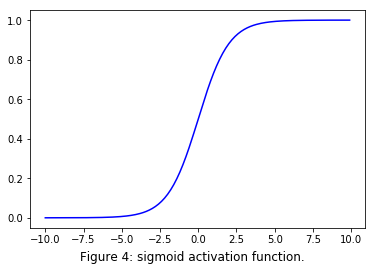

In [6]:
x_sig = np.arange(-10, 10, 0.1)
y_sig = sigmoid(x_sig)
plt.plot(x_sig,y_sig,color='blue')
plt.figtext(0.5, 0.01, 'Figure 4: sigmoid activation function.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

## Building the NN

As mentioned in the introduction, we will build a neural network (NN) with only one hidden layer, but with an arbitrary number of nodes in this hidden layer. We will also allow the NN to have as many input/output nodes as desired. We will keep track of this information with a three dimensional vector that counts the number of nodes in the input layer, the hidden layer and the output layer:

In [7]:
nodes = [2,5,1] 

The number of nodes in the hidden layer is a [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning) of the model. We will define our dataset by a matrix (features) whose rows are the training examples and a vector containing the target for each training example.

In [8]:
features = np.array([[-4,-4],[-4,4],[4,-4],[4,4]]) #Features or training examples
targets = np.array([1,0,0,1]) #Targets

Now, each layer $L$ of the NN has a weights matrix $\Theta^{(L)}_{ij}$ and a bias vector $b^{(L)}_n$ that control its activation (we define the input layer as layer $0$, the hidden layer as layer $1$ and the output layer as layer $2$). We define the activation of the layer $L$ of the NN by
$$
A^{(L)} = g\left(b^{(L)}+\Theta^{(L-1)}A^{(L-1)}\right),
$$
where $g$ is the sigmoid function acting componentwise on a vector. This is a number between $0$ and $1$, and can be thougth as the intensity of the output of the given neuron. Here the matrix entry $\Theta^{(L)}_{ij}$ represents the weight of the output of the $j-$th node from the layer $L-1$ in the input of the $i-$th node from layer $L$. This definition of the activation is recursive, and so it needs a first element to start. For a fixed training example $x$ (that is, a row of the features matrix), we define $A^{(0)}=x$. It is important to remark that this definition of activation is essential, as it says that a given node of a layer will activate depending on its weight and bias parameters, and the output produced by the previous layer nodes. 

Suppose we are trying to predict the results of a [XOR/XNOR](https://en.wikipedia.org/wiki/Exclusive_or) kind of dataset, as seen in the introduction. If we knew the right values for the weights and biases, then we would be able to make predictions. In fact, let us take

In [9]:
theta_1 = np.array([[20,20],[-20,-20]])
theta_2 = np.array([20,20])
bias_1 = np.array([-30,10])
bias_2 = np.array([-10])

Then if we compute the activation for the output layer for a given example, we obtain

In [10]:
x = np.array([1,1])
A_1 = sigmoid(bias_1+theta_1.dot(x))
A_2 = sigmoid(bias_2+theta_2.dot(A_1))
print(A_2)

[0.99995456]


If we perform the same computation with different points, we obtain the following values:

In [11]:
X = [np.array([1,1]),np.array([1,0]),np.array([0,1]),np.array([0,0]) ]
A_2 = [sigmoid(bias_2+theta_2.dot(sigmoid(bias_1+theta_1.dot(x)))) for x in X]
print(A_2)

[array([0.99995456]), array([4.54803785e-05]), array([4.54803785e-05]), array([0.99995456])]


This is a very close approximation to the truth table of the XNOR/XOR logic gate, which implies that our NN is in fact able to separate the dataset of the figure 1. But the question is now, how do we train the NN to obtain such parameters $\Theta$ and $b$?

## Training the NN

Our goal is to find the parameters $\Theta,b$ that are able to predict the outcome of the training examples with a reasonable degree of accuracy. To do this, we will use the **Backpropagation algorithm**.

### Initialization
We must initialize the parameters to some value, different to zero, as this would break the symmetry for the initial configuration (this makes less likely that the algorithm would get stuck right after initialization). Note that given that our NN has only one hidden layer, we will only need two matrices $\Theta$ and two vectors $b$ in order to model the system. The size of these parameters is completely determined by the entries of the nodes list. We have also added two elements to the lists containing the parameters, so the indexation used for the code coincides with the indexation used for the model.

In [12]:
def initialize_parameters(nodes):
    theta = [0,2*np.random.rand(nodes[1],features.shape[1])-1 ,2*np.random.rand(nodes[2],nodes[1])-1]
    bias = [0,2*np.random.rand(nodes[1])-1,2*np.random.rand(nodes[2])-1]
    return [theta,bias]

The idea is to adjust $\Theta$ and $b$ in a way that the prediction is more accurate for all training examples. We make this precise introducing a cost function to minimize, that takes into account the deviations from the prediction to the actual target value for each of the training examples.
$$
    C(\text{features},\text{targets},\Theta,b) =\frac{1}{m}\sum_{k=1}^m C_x(\Theta,b) = \frac{1}{m}\sum_{k=1}^m \dfrac{1}{2}\|A^{(2)}(k) - y(k) \|^2
$$
where the sum ranges over all the training examples, and $A^{(2)}(k)$ refers to the second layer activation computed with the $k-$th training example. We try to minimize this function using some well known ideas from Calculus. The basic principle is that if a function is smooth enough, then following the gradient of it, will (hopefully) lead us to a minimum of the function. Both variables $features$ and $targets$ remain fixed during the whole process, so we only need to optimize in the space of parameters $\Theta$ and $b$, so we are interested in $\nabla_\Theta C$ and $\nabla_b C$.

### Forward propagation

Let us fix a training example $x$, and observe that the cost function for this example can be written as
$$
C_x(\Theta,b) = \|A^{(2)} - y \|^2 = \|g(b^{(2)}+\Theta^{(1)}A^{(1)}) - y\|^2
$$

We define $z^{(2)} = b^{(2)}+\Theta^{(2)}A^{(1)}$, and analogously $z^{(1)}=b^{(1)}+\Theta^{(1)}A^{(0)}$. For indexation purposes, we also define $z^{(0)}=0$. Note that with this definition, we have that $A^{(2)}=g(z^{(2)})$ and $A^{(1)}=g(z^{(1)})$. With these definitions, we build now a function that for a given choice of parameters and training example, computes the predict output.

In [13]:
def propagation(features,theta,bias,i):
    Z = [0] 
    A = [features[i,:]]

    #Forward propagation phase. Here we propagate the neural network using the i-th training example
    Z.append(bias[1]+theta[1].dot(A[0]) )
    A.append(sigmoid(Z[1]))
    
    Z.append(bias[2]+theta[2].dot(A[1]))
    A.append(sigmoid(Z[2]))

    return [A,Z]

This function returns the activation values of each neuron of every layer of the NN. These values will later be used in the backwards propagation step. The second component of $A$ represents the current prediction for the $i-$th training example. If we compute the prediction for the first training example, we get a very skewed prediction:

In [14]:
[theta,bias] = initialize_parameters(nodes)
print(propagation(features,theta,bias,0)[0][2])

[0.36033001]


### Computation of the gradients

If we want to correct this prediction, then we have change the parameters according to the gradient (gradient descent):

\begin{align*}
\Theta &\mapsto \Theta - \lambda\nabla_\Theta C \\
b &\mapsto b - \lambda\nabla_b C.
\end{align*}

Here $\lambda$ is what we call the *learning rate*, and it represents the weight with which we substract the gradient from the parameters we are trying to fit. A large learning rate means that we move away from the current value of $\Theta$ very quickly, and thus, we can converge to the optimum in fewer iterations, but we risk missing the optimum as the step might be too large. A small learning rate is more likely to converge to the optimum, but it might take too many iterations for this to happen. The learning rate is another hyperparameter of the model.

In order to compute the gradients $\nabla_\Theta C$ and $\nabla_b C$, we ultimately need the derivatives $\dfrac{\partial C}{\partial \Theta^{(l)}_{jk}}$ and $\dfrac{\partial C}{\partial b^{(l)}_j}$. This is a very involved process, and relies mostly on the application of the chain rule. We show how to derive an expression for $\dfrac{\partial C}{\partial \Theta^{(2)}_{jk}}$ and then state without proof formulae for the other derivatives (their proofs are similar to the one we present).

**Lemma:**
$$
\dfrac{\partial C}{\partial \Theta^{(2)}_{jk}} = A_k^{(1)}g'(z_j^{(2)})(A^{(2)}_j - y_j ).
$$
**Proof:**
Recall that the cost of a fixed training example $C_x$ can be written as 
$$
C_x(\Theta,b)=\dfrac{1}{2}\|A^{(2)}-y \|^2=\dfrac{1}{2}(A^{(2)}-y)\cdot(A^{(2)}-y).
$$

Here $\cdot$ denotes the inner product. Then the derivative is
$$
\dfrac{\partial C}{\partial \Theta^{(2)}_{jk}} =\dfrac{\partial }{\partial \Theta^{(2)}_{jk}}\dfrac{1}{2}(A^{(2)}-y)\cdot(A^{(2)}-y) = (A^{(2)}-y)\cdot\dfrac{\partial }{\partial \Theta^{(2)}_{jk}}(A^{(2)}-y).
$$

We focus now on the derivative of the right hand side. Recalling that $A^{(2)}=g(z^{(2)})$, $z^{(2)}=b^{(2)}+\Theta^{(2)}A^{(1)}$ and that $A^{(1)}$ does **not** depend on $\Theta^{2}$, we obtain

\begin{align*}
\dfrac{\partial }{\partial \Theta^{(2)}_{jk}}(A^{(2)}-y) &=  \dfrac{\partial }{\partial \Theta^{(2)}_{jk}}g(b^{(2)}+\Theta^{(2)}A^{(1)}) = \dfrac{\mathrm{d}}{\mathrm{d}x}g(z^{(2)})\dfrac{\partial }{\partial \Theta^{(2)}_{jk}}\Theta^{(2)}A^{(1)}\\
&=g'(z^{(2)}) e_j A^{(1)}_k,
\end{align*}

where $e_j$ is a vector consisting of zeros except in the $j-$th component. This implies that

\begin{align*}
\dfrac{\partial C}{\partial \Theta^{(2)}_{jk}} = (A^{(2)}-y)\cdot\dfrac{\partial }{\partial \Theta^{(2)}_{jk}}(A^{(2)}-y) = A^{(1)}_k g'(z^{(2)})(A^{(2)}-y)\cdot e_j = A^{(1)}_kg'(z^{(2)})(A^{(2)}_j-y_j),
\end{align*}

as we wanted to prove. $\diamond$

This equation is particularly relevant, as it allows us to compute the derivative en terms of quantities which were obtained in the forward propagation step. We sumarize all the equations for the gradient:

\begin{align*}
\dfrac{\partial C}{\partial \Theta^{(2)}_{jk}} &= g'(z_j^{(2)})A_k^{(1)}(A^{(2)}_j - y_j ) \\
\dfrac{\partial C}{\partial b^{(2)}_{j}} &= g'(z^{2})(A^{(2)}_j-y_j) \\
\dfrac{\partial C}{\partial \Theta^{(1)}_{jk}} &= g'(z^{(1)}_j)A_{k}^{(0)}\sum_n \Theta^{(2)}_{nj}g'(z^{(2)}_n)(A^{(2)}_n-y_n)\\
\dfrac{\partial C}{\partial b^{(1)}_{j}} &=g'(z^{(1)}_j)\sum_n \Theta^{(2)}_{nj}g'(z^{(2)}_n)(A^{(2)}_n-y_n)
\end{align*}

This equations are componentwise, but they can be written in matrix form so we can make use of the optimized libraries from Python. For this, it is very useful to introduce the concept of **error at each node**. In fact, we define them in vectorized form by

\begin{align*}
\delta^{(2)} &= (A^{(2)}-y)\otimes g'(z^{(2)})   \\
\delta^{(1)} &= ((\Theta^{(2)})^T\delta^{(2)}) \otimes g'(z^{(1)}).
\end{align*}

Note that both of these quantities can be computed by using the values returned by the forward propagation function. With this, we can write the gradient for equations in a matrix form:

\begin{align*}
\dfrac{\partial C}{\partial \Theta^{(2)}} &= A^{(1)}\left((A^{(2)}-y)\otimes g'(z^{(2)})\right)^T,
\end{align*}

where $\otimes$ stands for the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product). Now we build a function that returns the gradients just computed. This will compute the gradient over all the training examples.

In [15]:
def cost(features,targets,bias,theta):
    cost = 0
    for i in range(features.shape[0]):
        A = propagation(features,theta,bias,i)[0]
        cost += (A[2]-targets[i])**2
    return cost/(features.shape[0])

In [16]:
def gradient(features,targets,theta,bias):
    grad_theta2 = np.zeros(theta[2].shape)
    grad_theta1 = np.zeros(theta[1].shape)
    grad_b2 = np.zeros(bias[2].shape)
    grad_b1 = np.zeros(bias[1].shape)
    for i in range(features.shape[0]):
        [A,Z] = propagation(features,theta,bias,i)
        delta2 = (A[2]-targets[i])*der_sigmoid(Z[2])  #this and the next
        delta1 = (theta[2].T.dot(delta2))*der_sigmoid(Z[1])  #seem to be right
        grad_theta2 += delta2.reshape(-1,1).dot(A[1].reshape(-1,1).T)
        grad_theta1 += delta1.reshape(-1,1).dot(features[i,:].reshape(-1,1).T)
        grad_b2 = delta2
        grad_b1 = delta1
    return [grad_theta2 , grad_theta1 , grad_b2 , grad_b1]

### Optimization: Gradient descent

Now that we have the gradient of the function we want to optimize, we can procede with the iterative process of gradient descent. For larger and more complex datasets or more complex architectures for the NN, this optimization method might not be very eficient, and some others such as stochastic gradient descent or BFGS might be more useful. 

We define then iterative process of gradient descent:

In [17]:
def gradient_descent(features,targets,bias,theta,learn_rate,num_iterations):
    temp_theta = theta[:]
    temp_bias = bias[:]
    cost_list = []
    for i in range(num_iterations):
        [grad_theta2 , grad_theta1 , grad_b2 , grad_b1] = gradient(features,targets,temp_theta,temp_bias)
        temp_theta[2] += -learn_rate*grad_theta2
        temp_theta[1] += -learn_rate*grad_theta1
        temp_bias[2] += -learn_rate*grad_b2
        temp_bias[1] += -learn_rate*grad_b1
        if i%100 == 0:
            cost_list.append(cost(features,targets,bias,theta))
    return [temp_theta,temp_bias,cost_list]

This function returns the optimized parameters, as well as a list of the cost function evaluated every $100$ iterations. This will be useful to make further predictions, to plot the cost function as a function of the number of iterations and to plot the decision boundary for this predictor.

In [18]:
def prediction(x,y,theta,bias):
    if propagation(np.array([[x,y],[0,1]]),theta,bias,0)[0][2] > 0.5:
        return 1
    else:
        return 0

### Running the model

Recall that our dataset consisted of the following points:

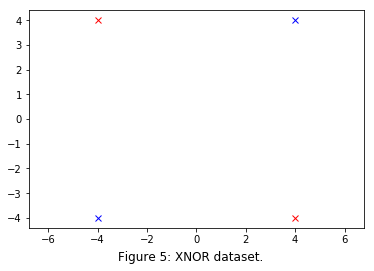

In [19]:
plt.plot([4,-4],[4,-4],'x',color='blue')
plt.plot([4,-4],[-4,4],'x',color='red')
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 5: XNOR dataset.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

We can now fit our NN and plot the cost function. We set the learning rate to $0.1$, the number of neurons in the hidden layer to $5$ and the number of iterations to $4000$.

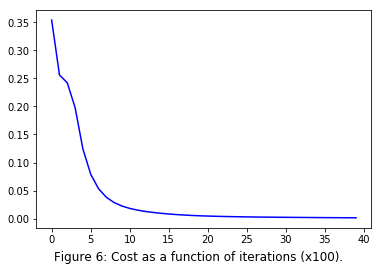

In [20]:
features = np.array([[-4,-4],[-4,4],[4,-4],[4,4]]) 
targets = np.array([1,0,0,1])
nodes = [2,5,1]
[theta,bias] = initialize_parameters(nodes)
[O,B,C] = gradient_descent(features,targets,bias,theta,0.1,4000)
plt.plot(range(40),C,color='blue')
plt.figtext(0.5, 0.01, 'Figure 6: Cost as a function of iterations (x100).', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

We can plot now the decision boundary and see how it separates the plan in different classes having the same value for the prediction function.

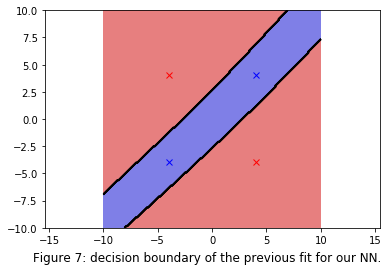

In [21]:
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
z = np.zeros(X.shape)
Z = np.array(z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = prediction(x[i],y[j],O,B)
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black')
plt.plot([4,-4],[4,-4],'x',color='blue')
plt.plot([4,-4],[-4,4],'x',color='red')
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 7: decision boundary of the previous fit for our NN.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

### One extra point

Let us see what happens when we add an additional point to our dataset.

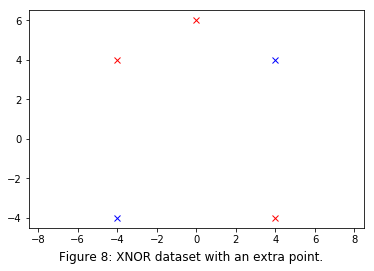

In [22]:
plt.plot([4,-4],[4,-4],'x',color='blue')
plt.plot([4,-4,0],[-4,4,6],'x',color='red')
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 8: XNOR dataset with an extra point.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

We fit try to fit the NN with the same parameters as before. This time, given the irregularity of the dataset, we might not get the expected results. For instance, it might happen that the cost function does not decrease as we iterate the process. In this case, it is recommended to run the model several times, so we can initialize it with different random values, and hence, have the possibility to converge to a different local minimum.

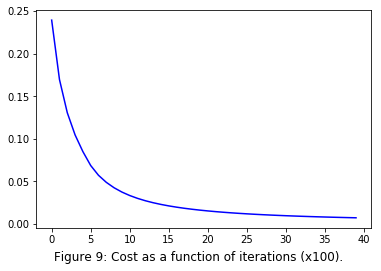

In [23]:
features = np.array([[-4,-4],[-4,4],[4,-4],[4,4],[0,6]]) #Features or training examples
targets = np.array([1,0,0,1,0]) #Targets
nodes = [2,10,1]
[theta,bias] = initialize_parameters(nodes)
[O,B,C] = gradient_descent(features,targets,bias,theta,0.1,4000)
plt.plot(range(40),C,color='blue')
plt.figtext(0.5, 0.01, 'Figure 9: Cost as a function of iterations (x100).', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

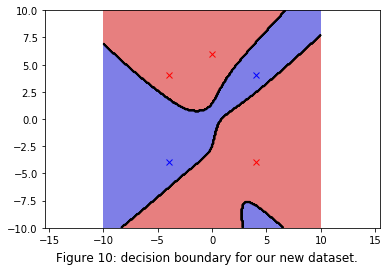

In [24]:
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
z = np.zeros(X.shape)
Z = np.array(z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = prediction(x[i],y[j],O,B)
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black')
plt.plot([4,-4],[4,-4],'x',color='blue')
plt.plot([4,-4,0],[-4,4,6],'x',color='red')
plt.axis('equal')
plt.figtext(0.5, 0.01, 'Figure 10: decision boundary for our new dataset.', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


We can see that the decision boundary now looks more complicated, but it still somehow fits the points in the right classes after several trials. Although,tt is important to note that this model overfits this data, as we will discuss in further notebooks. We finish by mentioning that even though the dataset used in this notebook, our humble Neural Network counts with the full power of a single hidden layer NN, and is capable of fitting much more complex datasets. The more general case of multiple hidden layers is treated similarly but the notation becomes much more involved.